# Comparação Experimental de Técnicas de Classificação

Este trabalho tem como objetivo realizar uma **comparação experimental** entre um conjunto pré-definido de técnicas de aprendizado e classificação automática aplicadas a um problema de **classificação supervisionada**.

## Técnicas Utilizadas

As seguintes técnicas de aprendizado serão avaliadas:

- **Decision Tree (DT)**
- **K Nearest Neighbors (KNN)**
- **Multi-layer Perceptron (MLP)**
- **Random Forest (RF)**
- **Heterogeneous Boosting (HB)**

## Procedimento Experimental

O experimento será conduzido em **3 rodadas** de ciclos aninhados de validação e teste, organizados da seguinte forma:

- **Validação interna:** 4 folds
- **Teste externo:** 10 folds

A seleção de hiperparâmetros será realizada por **busca em grade** (_grid search_) no ciclo interno, com os seguintes valores para cada técnica:

### Hiperparâmetros

```python
# Decision Tree (DT)
{
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 25]
}

# K Nearest Neighbors (KNN)
{
    'n_neighbors': [1, 3, 5, 7, 9]
}

# Multi-layer Perceptron (MLP)
{
    'hidden_layer_sizes': [(100,), (10,)],
    'alpha': [0.0001, 0.005],
    'learning_rate': ['constant', 'adaptive']
}

# Random Forest (RF)
{
    'n_estimators': [5, 10, 15, 25],
    'max_depth': [10, None]
}

# Heterogeneous Boosting (HB)
{
    'n_estimators': [5, 10, 15, 25, 50]
}


# Imports

In [30]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# (Exemplo de Heterogeneous Boosting com Gradient Boosting)
from sklearn.ensemble import GradientBoostingClassifier

# Validação cruzada e avaliação
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from scipy import stats

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Criação do Heterogeneous Boosting
from sklearn.utils import resample
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode
from collections import Counter

from tqdm import tqdm


# Configurações de exibição

In [31]:
# Configurações gerais de visualização
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
warnings.filterwarnings("ignore")

# Importando base de dados

In [32]:
data = pd.read_csv("jogosLoL2021.csv")

In [33]:
data

,id,result,golddiffat15,xpdiffat15,csdiffat15,killsdiffat15,assistsdiffat15,golddiffat10,xpdiffat10,csdiffat10,...,OPP_EGR,OPP_MLR,OPP_FB%,OPP_FT%,OPP_F3T%,OPP_HLD%,OPP_DRG%,OPP_BN%,OPP_LNE%,OPP_JNG%
0,10,1,5018.0,4255.0,86.0,5.0,9.0,1793.0,2365.0,65.0,...,23.1,-23.1,0,0,33,50,27,0,49.2,43.7
1,22,0,573.0,-1879.0,-49.0,1.0,4.0,759.0,171.0,-8.0,...,77.2,22.8,100,100,100,58,70,89,50.4,53.3
2,34,0,-579.0,-1643.0,-40.0,-1.0,-5.0,73.0,-1.0,-24.0,...,77.2,22.8,100,100,100,58,70,89,50.4,53.3
3,106,1,3739.0,1118.0,53.0,1.0,0.0,1746.0,824.0,21.0,...,63.9,-3.9,67,67,67,48,60,48,51.6,50.3
4,118,0,-6390.0,-4569.0,-47.0,-10.0,-17.0,-3500.0,-1882.0,-18.0,...,25.8,-0.8,13,25,25,19,20,20,49.7,42.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8147,138358,1,7581.0,3246.0,6.0,9.0,17.0,1928.0,469.0,-4.0,...,53.9,4.9,59,76,59,65,46,65,50.4,52.1
8148,138370,0,-2828.0,-2139.0,-33.0,-3.0,-5.0,-1325.0,-677.0,-20.0,...,61.2,-11.2,70,60,60,55,53,47,50.9,48.0
8149,138382,0,1427.0,-142.0,-21.0,0.0,-6.0,671.0,1446.0,-20.0,...,53.9,4.9,59,76,59,65,46,65,50.4,52.1
8150,138394,0,-1286.0,-2414.0,-56.0,1.0,-6.0,1002.0,-72.0,-40.0,...,51.3,8.7,40,60,60,70,48,57,48.9,54.2


# Pré-processamento dos dados

**Descartar o identificador da partida** e realizar a **padronização das características numéricas** (normalização).

As características que usaremos são os dados pré-jogos, ou seja, as informações disponíveis antes do início da partida, como:

- WR (Win-Rate do Time Azul)
- KD (Kill-to-Death Ratio do Time Azul)
- GPR (Gold Percent Ratio do Time Azul)
- GSPD (Average Gold Spent Ratio do Time Azul)
- EGR (Early-Game-Rate do Time Azul)
- MLR (Mid-Late-Game-Rate do Time Azul)
- FB% (First Blood Rate do Time Azul)
- FT% (First Blood Rate do Time Azul)
- F3T% (First To Three Towers Rate do Time Azul)
- HLD% (Harold Rate do Time Azul)
- DRG% (Dragon Rate do Time Azul)
- BN% (First Blood Rate do Time Azul)
- LNE% (Lane Control Rate do Time Azul)
- JNG% (Jungle Control Rate do Time Azul)
- OPP_WR (Win-Rate do Time Vermelho)
- OPP_KD (Kill-to-Death Ratio do Time Vermelho)
- OPP_GPR (gold Percent Ratio) do Time Vermelho
- OPP_GSPD (Average Gold Spent Ratio do Time Vermelho)
- OPP_EGR (Early-Game-Rate do Time Vermelho)
- OPP_MLR (Mid-Late-Game-Rate do Time Vermelho)
- OPP_FB% (First Blood Rate do Time Vermelho)
- OPP_FT% (First Blood Rate do Time Vermelho)
- OPP_F3T% (First To Three Towers Rate do Time Vermelho)
- OPP_HLD% (Harold Rate do Time Vermelho)
- OPP_DRG% (Dragon Rate do Time Vermelho)
- OPP_BN% (First Blood Rate do Time Vermelho)
- OPP_LNE% (Lane Control Rate do Time Vermelho)
- OPP_JNG% (Jungle Control Rate do Time Vermelho)

Iremos excluir, portanto, as colunas:

- golddiffat15 (Diferença de gold entre os times aos 15 minutos)
- xpdiffat15 (Diferença de XP entre os times aos 15 minutos)
- csdiffat15 (Diferença de creeps entre os times aos 15 minutos)
- killsdiffat15 (Diferença de kills entre os times aos 15 minutos)
- assistsdiffat15 (Diferença de assists entre os times aos 15 minutos)
- golddiffat10 (Diferença de gold entre os times aos 10 minutos)
- xpdiffat10 (Diferença de xp entre os times aos 10 minutos)
- csdiffat10 (Diferença de creeps entre os times aos 10 minutos)
- killsdiffat10 (Diferença de kills entre os times aos 10 minutos)
- assistsdiffat10 (Diferença de assists entre os times aos 10 minutos)

In [34]:
# Descarte do identificador da partida
data = data.drop(columns=['id'])
# Descarte de colunas que não serão utilizadas
data = data.drop(columns= ['golddiffat15', 'xpdiffat15', 'csdiffat15', 'killsdiffat15', 'assistsdiffat15', 'golddiffat10', 'xpdiffat10', 'csdiffat10', 'killsdiffat10', 'assistsdiffat10'])

In [35]:
# Normalizando as colunas numéricas
# Seleciona as colunas numéricas (todas exceto 'result')
cols_to_normalize = data.columns.drop('result')

# Aplica MinMaxScaler para normalizar entre 0 e 1
scaler = MinMaxScaler()
data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
X = data.drop(columns=['result'])
y = data['result']

# Vai armazenar os resultados dos classfiicadores (quando forem executados)
resultados = {}

## Implementação do Hetergeneos Boosting

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import resample
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from sklearn.naive_bayes import GaussianNB  # Importando GaussianNB corretamente

class HeterogeneousBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=1):
        self.n_estimators = n_estimators
        self.base_models = [
            GaussianNB(),  # Naive Bayes
            DecisionTreeClassifier(random_state=13),  # Decision Tree
            MLPClassifier(max_iter=5, random_state=13),  # Multi-layer Perceptron
            KNeighborsClassifier()  # K-Nearest Neighbors
        ]
        self.trained_models = []

    def fit(self, X, y):
         n_samples = X.shape[0]
         self.most_frequent_class = mode(y, keepdims=True).mode[0]
         sample_weights = np.ones(n_samples, dtype=float)
         self.trained_models = []
 
         for i in range(self.n_estimators):
             indices = np.random.choice(
                 np.arange(n_samples),
                 size=n_samples, # Tamanho do resample é igual ao tamnho original, não deveria ser
                 replace=True,
                 p=sample_weights / sample_weights.sum()
             )
             X_resampled = X.iloc[indices]
             y_resampled = y.iloc[indices]

             best_model = None
             best_accuracy = -1
             best_model_index = None
 
             for idx, base_model in enumerate(self.base_models):
                 model = clone(base_model)
                 model.fit(X_resampled, y_resampled)
                 y_pred = model.predict(X_resampled)
 
                 accuracy = (y_pred == y_resampled).mean()
 
                 if (accuracy > best_accuracy) or (
                     accuracy == best_accuracy and self._prefer(idx, best_model_index)
                 ):
                     best_model = model
                     best_accuracy = accuracy
                     best_model_index = idx

            # Printa o melhor modelo treinado
             # print(f"Iteração {i+1}/{self.n_estimators}: Melhor modelo = {type(best_model).__name__}, Acurácia = {best_accuracy:.4f}")
             y_pred_full = best_model.predict(X)
             incorrect_mask = (y_pred_full != y)
 
             # Dobra os pesos dos exemplos classificados incorretamente
             sample_weights[incorrect_mask] *= 2

             self.trained_models.append(best_model)




    def _prefer(self, idx1, idx2):
        # Preferência: MLP (2) > DT (1) > KNN (3) > NB (0)
        preference = [0, 1, 2, 3]
        if idx2 is None:
            return True
        return preference[idx1] > preference[idx2]


    def predict(self, X):
        n_samples = X.shape[0]
        all_preds = np.vstack([model.predict(X) for model in self.trained_models])

        final_preds = []
        for i in range(n_samples):
            # Votos dos classificadores para a i-ésima amostra
            votes = all_preds[:, i]
            vote_counts = Counter(votes)
            max_votes = max(vote_counts.values())
    
            # Classes mais votadas (pode haver empate)
            most_voted_classes = [cls for cls, count in vote_counts.items() if count == max_votes]
    
            if len(most_voted_classes) == 1:
                final_preds.append(most_voted_classes[0])
            else:
                # Desempate: retorna a mais frequente na base de treino entre as empatadas
                if self.most_frequent_class in most_voted_classes:
                    final_preds.append(self.most_frequent_class)
                else:
                    # Se por algum motivo ela não estiver (muito raro), pega a primeira empatada
                    final_preds.append(most_voted_classes[0])
        
        return np.array(final_preds)

    def predict_proba(self, X):
        proba_preds = []
        for model in self.trained_models:
            if hasattr(model, "predict_proba"):
                proba_preds.append(model.predict_proba(X))
        if proba_preds:
            return np.mean(proba_preds, axis=0)
        else:
            raise ValueError("Nenhum modelo no ensemble suporta `predict_proba`.")


## Função de treino-teste do modelo

In [ ]:
def train_and_evaluate_model(model, X, y):
    """
    Treina e avalia o modelo usando validação cruzada com barra de progresso.
    """
    if model == "DT":
        model = DecisionTreeClassifier(random_state=13)
        param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 25]
        }
    elif model == "KNN":
        model = KNeighborsClassifier()
        param_grid = {
            'n_neighbors':[1,3,5,7,9]
        }
    elif model == "MLP":
        model = MLPClassifier(max_iter=5, random_state=13)
        param_grid = {
            'hidden_layer_sizes': [(100,),(10,)],
            'alpha': [0.0001, 0.005],
            'learning_rate': ['constant','adaptive']
        }
    elif model == "RF":
        model = RandomForestClassifier(random_state=13)
        param_grid = {
            'n_estimators': [5, 10, 15, 25],
            'max_depth': [10, None]
        }
    elif model == "HB":
        model = HeterogeneousBoosting()
        param_grid = {
            'n_estimators': [5, 10, 15, 25, 50]
        }
    else:
        raise ValueError(f"Modelo '{model}' não reconhecido.")

    outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36854321)

    scores = []

    # Use tqdm para exibir barra de progresso no loop externo
    for train_idx, test_idx in tqdm(outer_cv.split(X, y), total=outer_cv.get_n_splits(), desc=f"Validando {model.__class__.__name__}"):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        inner_cv = StratifiedKFold(n_splits=4)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

    return scores


## Funções úteis

In [38]:
def t_corrigido_nadeau_bengio(data1, data2, X, n_folds_externos):
    """
    Parâmetros:
    data1, data2: listas ou arrays com as acurácias

    X: conjunto de dados original
    n_folds_externos: número de folds no loop externo
    Retorna:
    t_stat: valor da estatística t
    p_valor: valor-p do teste bilateral
    """
    N = len(X) # número total de amostras no dataset
    n = len(data1) # número de execuções
    # Tamanhos dos conjuntos de treino/teste em cada fold externo
    n_test = N // n_folds_externos
    n_train = N - n_test
    # Cálculo da estatística t com correção
    diffs = np.array(data1) - np.array(data2)
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, ddof=1)
    se_corrigido = std_diff * np.sqrt(1/n + n_test/n_train)
    t_stat = mean_diff / se_corrigido
    p_valor = 2 * (1 - t.cdf(abs(t_stat), df=n - 1))
    return t_stat, p_valor
    print('\nCorrected T Test')
    s,p = t_corrigido_nadeau_bengio(scores,scoresWN,iris_X,10)
    print("t: %0.2f p-value: %0.2f\n" % (s,p))

## Decision Tree (DT)

In [39]:
scores = train_and_evaluate_model("DT", X, y)

print(f"Acurácias: {scores}")
print(f"Média: {np.mean(scores):.3f}, Desvio padrão: {np.std(scores):.3f}")

resultados["DT"] = scores


Validando DecisionTreeClassifier: 100%|██████████| 30/30 [00:13<00:00,  2.24it/s]

Acurácias: [0.6041666666666666, 0.5625, 0.5828220858895705, 0.5742331288343558, 0.5877300613496933, 0.5901840490797546, 0.5730061349693252, 0.5742331288343558, 0.592638036809816, 0.6012269938650306, 0.5808823529411765, 0.5821078431372549, 0.5730061349693252, 0.5803680981595092, 0.5766871165644172, 0.592638036809816, 0.5803680981595092, 0.6073619631901841, 0.5950920245398773, 0.6110429447852761, 0.5698529411764706, 0.6213235294117647, 0.5815950920245399, 0.5950920245398773, 0.5644171779141104, 0.5803680981595092, 0.5914110429447853, 0.6, 0.5852760736196319, 0.5865030674846625]
Média: 0.587, Desvio padrão: 0.014


## K Nearnest Neighbor (KNN)

In [40]:
scores = train_and_evaluate_model("KNN", X, y)

print(f"Acurácias: {scores}")
print(f"Média: {np.mean(scores):.3f}, Desvio padrão: {np.std(scores):.3f}")

resultados["KNN"] = scores

Validando KNeighborsClassifier: 100%|██████████| 30/30 [00:10<00:00,  2.95it/s]

Acurácias: [0.5919117647058824, 0.5833333333333334, 0.5766871165644172, 0.561963190184049, 0.6024539877300613, 0.596319018404908, 0.5901840490797546, 0.5754601226993865, 0.5779141104294478, 0.6196319018404908, 0.5698529411764706, 0.5588235294117647, 0.6, 0.5717791411042945, 0.5656441717791411, 0.5815950920245399, 0.5852760736196319, 0.6208588957055214, 0.5742331288343558, 0.5914110429447853, 0.5784313725490197, 0.5955882352941176, 0.596319018404908, 0.5852760736196319, 0.5865030674846625, 0.5656441717791411, 0.5791411042944785, 0.5938650306748466, 0.5766871165644172, 0.5533742331288344]
Média: 0.584, Desvio padrão: 0.016


## Multi Layer Perceptron (MLP)

In [41]:
scores = train_and_evaluate_model("MLP", X, y)

print(f"Acurácias: {scores}")
print(f"Média: {np.mean(scores):.3f}, Desvio padrão: {np.std(scores):.3f}")

resultados["MLP"] = scores

Validando MLPClassifier: 100%|██████████| 30/30 [00:10<00:00,  2.99it/s]

Acurácias: [0.6127450980392157, 0.5674019607843137, 0.603680981595092, 0.5668711656441717, 0.6085889570552148, 0.588957055214724, 0.5950920245398773, 0.588957055214724, 0.5987730061349693, 0.5840490797546012, 0.5882352941176471, 0.5735294117647058, 0.5754601226993865, 0.592638036809816, 0.6196319018404908, 0.6049079754601226, 0.5656441717791411, 0.6098159509202454, 0.5938650306748466, 0.6012269938650306, 0.5821078431372549, 0.6115196078431373, 0.592638036809816, 0.6085889570552148, 0.5901840490797546, 0.6061349693251534, 0.5877300613496933, 0.5950920245398773, 0.5815950920245399, 0.603680981595092]
Média: 0.593, Desvio padrão: 0.014


## Random Forest (RF)

In [42]:
scores = train_and_evaluate_model("RF", X, y)

print(f"Acurácias: {scores}")
print(f"Média: {np.mean(scores):.3f}, Desvio padrão: {np.std(scores):.3f}")

resultados["RF"] = scores

Validando RandomForestClassifier: 100%|██████████| 30/30 [00:22<00:00,  1.31it/s]

Acurácias: [0.6151960784313726, 0.6311274509803921, 0.6049079754601226, 0.5828220858895705, 0.6368098159509202, 0.6024539877300613, 0.5791411042944785, 0.6110429447852761, 0.603680981595092, 0.6269938650306749, 0.5857843137254902, 0.6004901960784313, 0.6233128834355828, 0.5852760736196319, 0.6098159509202454, 0.6233128834355828, 0.6012269938650306, 0.6208588957055214, 0.5987730061349693, 0.6417177914110429, 0.5882352941176471, 0.6507352941176471, 0.6122699386503068, 0.592638036809816, 0.6098159509202454, 0.6110429447852761, 0.6196319018404908, 0.6417177914110429, 0.6257668711656442, 0.592638036809816]
Média: 0.611, Desvio padrão: 0.019


## Heterogeneous Boosting (HB) 

In [43]:
scores = train_and_evaluate_model("HB", X, y)

print(f"Acurácias: {scores}")
print(f"Média: {np.mean(scores):.3f}, Desvio padrão: {np.std(scores):.3f}")

resultados["HB"] = scores

Validando HeterogeneousBoosting: 100%|██████████| 30/30 [15:08<00:00, 30.28s/it]

Acurácias: [0.5637254901960784, 0.5968137254901961, 0.5754601226993865, 0.5840490797546012, 0.6147239263803681, 0.5901840490797546, 0.6122699386503068, 0.5791411042944785, 0.5693251533742332, 0.5950920245398773, 0.5833333333333334, 0.5919117647058824, 0.6184049079754601, 0.5656441717791411, 0.5631901840490797, 0.6110429447852761, 0.5742331288343558, 0.5987730061349693, 0.5730061349693252, 0.6294478527607362, 0.5796568627450981, 0.6139705882352942, 0.5865030674846625, 0.5730061349693252, 0.5693251533742332, 0.5901840490797546, 0.603680981595092, 0.6380368098159509, 0.6147239263803681, 0.5595092024539877]
Média: 0.591, Desvio padrão: 0.021


In [52]:
import pandas as pd
import numpy as np
from scipy.stats import t

def calcular_ic95(scores):
    mean = np.mean(scores)
    std = np.std(scores, ddof=1)
    n = len(scores)
    conf = 0.95
    h = t.ppf((1 + conf) / 2, df=n - 1) * std / np.sqrt(n)
    return mean, std, mean - h, mean + h

tabela = []

for metodo, scores in resultados.items():
    media, desvio, inf, sup = calcular_ic95(scores)
    tabela.append([metodo, round(media, 3), round(desvio, 3), round(inf, 3), round(sup, 3)])
df_tabela = pd.DataFrame(tabela, columns=['Método', 'Média', 'Desvio Padrão', 'IC 95% Inferior', 'IC 95% Superior'])
df_tabela.set_index('Método', inplace=True)
df_tabela.index.name = None  # Remove o nome do índice
display(df_tabela)


,Média,Desvio Padrão,IC 95% Inferior,IC 95% Superior
DT,0.587,0.014,0.581,0.592
KNN,0.584,0.016,0.578,0.589
MLP,0.593,0.014,0.588,0.599
RF,0.611,0.019,0.604,0.618
HB,0.591,0.021,0.583,0.598


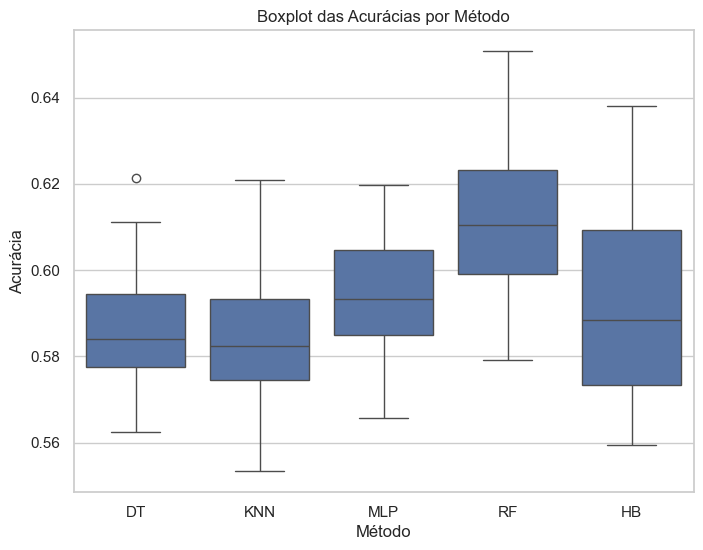

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transforma os dados para formato longo
df_long = pd.DataFrame([
    {'Método': metodo, 'Acurácia': acc}
    for metodo, scores in resultados.items()
    for acc in scores
])

plt.figure(figsize=(8,6))
sns.boxplot(data=df_long, x='Método', y='Acurácia')
plt.title("Boxplot das Acurácias por Método")
plt.show()


In [54]:
from scipy import stats

metodos = list(resultados.keys())
n = len(metodos)
matriz = pd.DataFrame("", index=metodos, columns=metodos)

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        scores1 = resultados[metodos[i]]
        scores2 = resultados[metodos[j]]
        if i < j:
            # Triângulo superior: t pareado
            stat, p = t_corrigido_nadeau_bengio(scores1, scores2, X, 30)
        else:
            # Triângulo inferior: Wilcoxon
            stat, p = stats.wilcoxon(scores1, scores2)
        # Se p < 0.001, exibe 0.001
        p_show = 0.001 if p < 0.001 else p
        txt = f"**{p_show:.3f}**" if p < 0.05 else f"{p_show:.3f}"
        matriz.iloc[i, j] = txt

print("\nMatriz de Testes de Hipóteses (p-valores):")
display(matriz)



Matriz de Testes de Hipóteses (p-valores):


,DT,KNN,MLP,RF,HB
DT,,0.468,0.072,**0.001**,0.476
KNN,0.349,,0.072,**0.001**,0.182
MLP,**0.020**,**0.012**,,**0.003**,0.698
RF,**0.001**,**0.001**,**0.001**,,**0.001**
HB,0.375,0.086,0.651,**0.001**,
